In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
scripts_path = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "scripts"))

# Add the "scripts" directory to the Python path if it's not already present.
if scripts_path not in sys.path:
    sys.path.insert(0, scripts_path)

In [17]:
# Now import the module
import data_ingestion
import data_validator

# evaluate dataframe and energy features

In [27]:
# Test the import:
dirpath = "/Volumes/LaCie_d2_Professional_Media/absolut_antibody/PerClass/RawBindingsPerClassMurine/extracted/processed/"
df = data_ingestion.load_processed_csvs(dirpath, 1)
print(df.shape)

(853499, 9)


In [28]:
df = data_validator.add_sequence_lengths(df)
df = data_validator.validate_dataframe(df, verbose=True, dedup_columns='CDR3')

Initial DataFrame shape: (853499, 11)
No missing values found.

Data types of columns:
ID_slide_Variant       object
CDR3                   object
Best                     bool
Slide                  object
Energy                float64
Structure              object
antigen                object
antigen_sequence       object
binding_class          object
CDR3_length             int64
antigen_seq_length      int64
dtype: object

Rows before deduplication on CDR3: 853499
Rows after deduplication on CDR3: 814784


/var/folders/lg/dh15rq991nb0srz_jbgtk8f80000gn/T/ipykernel_93373/770173761.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x="binding_class", y="Energy", palette="viridis", inner="quartile")
/Users/meow/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


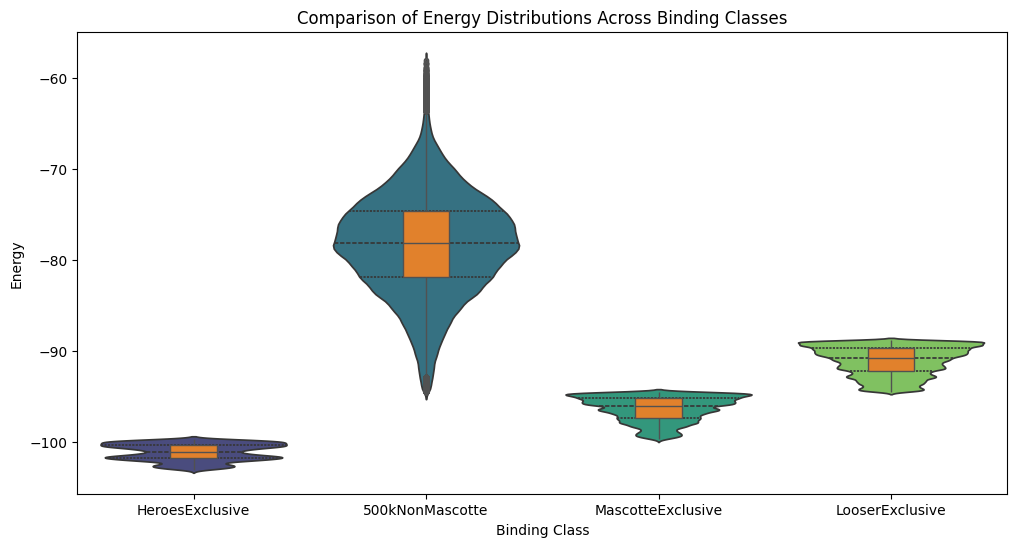

/Users/meow/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


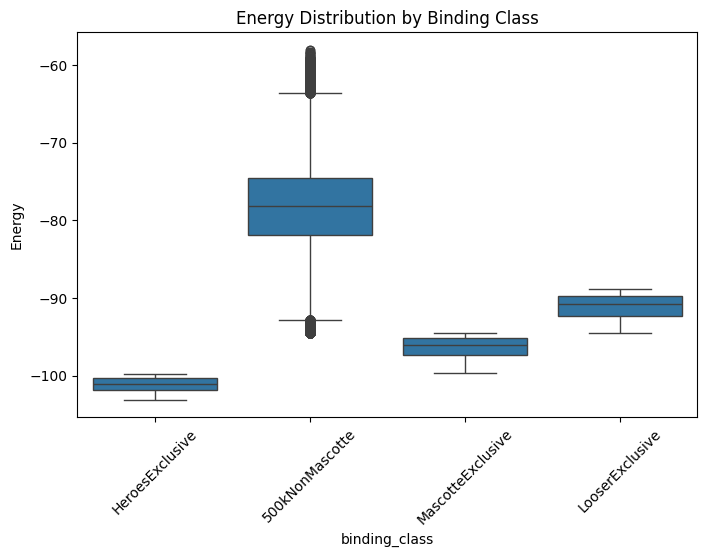

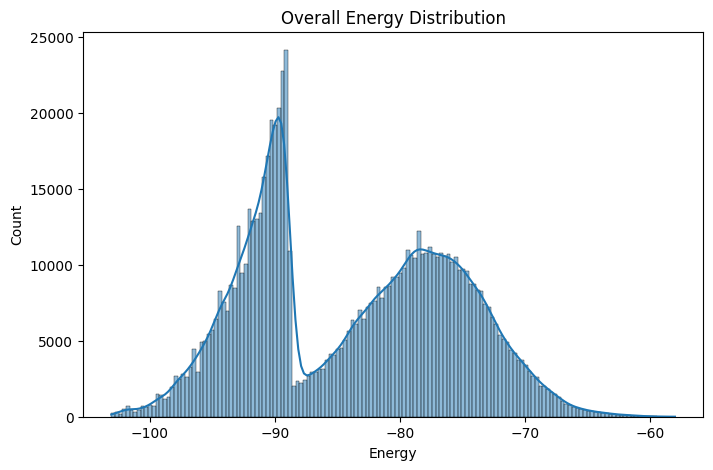

In [29]:
#Validate the poor energy scores are mapped to classes correctly

data = df

# Set figure size
plt.figure(figsize=(12, 6))

# Violin plot to show energy distribution per binding class
sns.violinplot(data, x="binding_class", y="Energy", palette="viridis", inner="quartile")

# Box plot overlay for summary statistics
sns.boxplot(data, x="binding_class", y="Energy", width=0.2, boxprops={'zorder': 2}, showcaps=False, fliersize=3)

# Labels and title
plt.xlabel("Binding Class")
plt.ylabel("Energy")
plt.title("Comparison of Energy Distributions Across Binding Classes")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x='binding_class', y='Energy', data=df)
plt.title("Energy Distribution by Binding Class")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df['Energy'], kde=True)
plt.title("Overall Energy Distribution")
plt.show()

# evaluate sequence variation using mmseqs2

In [52]:
!brew install mmseqs2

==> Downloading https://formulae.brew.sh/api/formula.jws.json
==> Downloading https://formulae.brew.sh/api/cask.jws.json
==> Downloading https://ghcr.io/v2/homebrew/core/mmseqs2/manifests/17-b804f
######################################################################### 100.0%
==> Fetching dependencies for mmseqs2: gettext, ca-certificates and libomp
==> Downloading https://ghcr.io/v2/homebrew/core/gettext/manifests/0.23.1
######################################################################### 100.0%
==> Fetching gettext
==> Downloading https://ghcr.io/v2/homebrew/core/gettext/blobs/sha256:f3b350830a
######################################################################### 100.0% 15.2%
==> Downloading https://ghcr.io/v2/homebrew/core/ca-certificates/manifests/2024-
######################################################################### 100.0%
==> Fetching ca-certificates
==> Downloading https://ghcr.io/v2/homebrew/core/ca-certificates/blobs/sha256:41
###############################

#### Mseqs isn't a native python library, but bu writing out a fasta we can use subprocess to run it quickly

In [133]:
seqs = df['CDR3'].tolist()
headers = [f'>{label}' for label in df['ID_slide_Variant']]
handle = df['antigen'].iloc[0]+'.fasta'
fpath = os.path.join(dirpath,handle)
with open(fpath,'w') as f:
    for header, sequence in zip(headers,seqs):
        f.write(header+'\n')
        f.write(sequence+'\n')
    print(f'Completed writing fasta to {fpath}')
    f.close()

Completed writing fasta to /Volumes/LaCie_d2_Professional_Media/absolut_antibody/PerClass/RawBindingsPerClassMurine/extracted/processed/3KR3_D.fasta


In [176]:
import os
import subprocess


input_fasta = fpath  # Input FASTA file
db_path = os.path.join(dirpath, handle+"_db")
output_dir = os.path.join(dirpath, "mmseqs2_output")
tmp_dir = os.path.join(dirpath, "tmp")
cluster_identity = 0.90  # Similarity threshold

# Ensure that the output and tmp directories exist (or remove them if they exist)
if os.path.exists(output_dir):
    print(f"Removing existing output directory: {output_dir}")
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

if os.path.exists(tmp_dir):
    print(f"Removing existing temporary directory: {tmp_dir}")
    shutil.rmtree(tmp_dir)
os.makedirs(tmp_dir, exist_ok=True)

# Before clustering, create an MMseqs2 database from the FASTA file.
# (This step requires the --dbtype flag to specify that the input is an amino acid database.)
db_path = input_fasta + "_db"  # output path for the created database


# Step 1: Create a MMseqs2 database from the input FASTA file, specifying it's an amino acid database (--dbtype 1)
cmd_createdb = [
    "mmseqs", "createdb", input_fasta, db_path, "--dbtype", "1"
]

try:
    result_db = subprocess.run(cmd_createdb, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    print("Database created successfully.")
    print(result_db.stdout)
except subprocess.CalledProcessError as e:
    print("Error during database creation:")
    print("Return code:", e.returncode)
    print("Stdout:", e.stdout)
    print("Stderr:", e.stderr)
    raise

# Step 2: Cluster the sequences using the created database
# Using --cov-mode 2 forces MMseqs2 to consider the alignment coverage for both the query and target sequences.
# This is critical when full-length alignment of the target sequence matters, ensuring that alignments are not
# accepted unless they cover a substantial fraction of both sequences.
cmd_cluster = [
    "mmseqs", "cluster", db_path, output_dir, tmp_dir,
    "--min-seq-id", str(cluster_identity),
    "--cov-mode", "2"
]

try:
    result_cluster = subprocess.run(cmd_cluster, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    print("Clustering executed successfully.")
    print(result_cluster.stdout)
except subprocess.CalledProcessError as e:
    print("Error during clustering:")
    print("Return code:", e.returncode)
    print("Stdout:", e.stdout)
    print("Stderr:", e.stderr)
    raise

Removing existing temporary directory: /Volumes/LaCie_d2_Professional_Media/absolut_antibody/PerClass/RawBindingsPerClassMurine/extracted/processed/tmp
Database created successfully.
createdb /Volumes/LaCie_d2_Professional_Media/absolut_antibody/PerClass/RawBindingsPerClassMurine/extracted/processed/3KR3_D.fasta /Volumes/LaCie_d2_Professional_Media/absolut_antibody/PerClass/RawBindingsPerClassMurine/extracted/processed/3KR3_D.fasta_db --dbtype 1 

MMseqs Version:       	17-b804f
Database type         	1
Shuffle input database	true
Createdb mode         	0
Write lookup file     	1
Offset of numeric ids 	0
Compressed            	0
Verbosity             	3

Converting sequences
[==================================================================================
Time for merging to 3KR3_D.fasta_db_h: 0h 0m 0s 103ms
Time for merging to 3KR3_D.fasta_db: 0h 0m 0s 99ms
Database type: Aminoacid
Time for processing: 0h 0m 1s 425ms

Clustering executed successfully.
/Volumes/LaCie_d2_Professional_

In [177]:
from Bio import SeqIO


# Define the TSV file output path
tsv_file = os.path.join(dirpath, "cluster.tsv")

# Convert the clustering result to a TSV file if not already done.
cmd_createtsv = ["mmseqs", "createtsv", db_path, output_dir, tsv_file]
try:
    result = subprocess.run(cmd_createtsv, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    print("Cluster TSV created successfully.")
except subprocess.CalledProcessError as e:
    print("Error creating TSV:")
    print("Return code:", e.returncode)
    print("Stdout:", e.stdout)
    print("Stderr:", e.stderr)

Cluster TSV created successfully.


In [178]:
# Load the TSV file.
# The TSV is assumed to have two columns: representative and member.
df_cluster = pd.read_csv(tsv_file, sep="\t", header=None, names=["rep", "member"])
print("Cluster TSV sample:")
display(df_cluster.head())

Cluster TSV sample:


,rep,member
0,18_02a,0
1,18_02a,670216
2,18_02a,725412
3,18_02a,121311
4,18_02a,129519


In [179]:
# Compute cluster sizes: count how many sequences belong to each cluster (by representative)
cluster_sizes = df_cluster.groupby("rep").size().reset_index(name="cluster_size")
cluster_sizes['cluster_size'].value_counts()[0:10]

cluster_size
1     501572
2      78059
3      23705
4       9358
5       4338
6       2260
7       1198
8        685
9        421
10       279
Name: count, dtype: int64

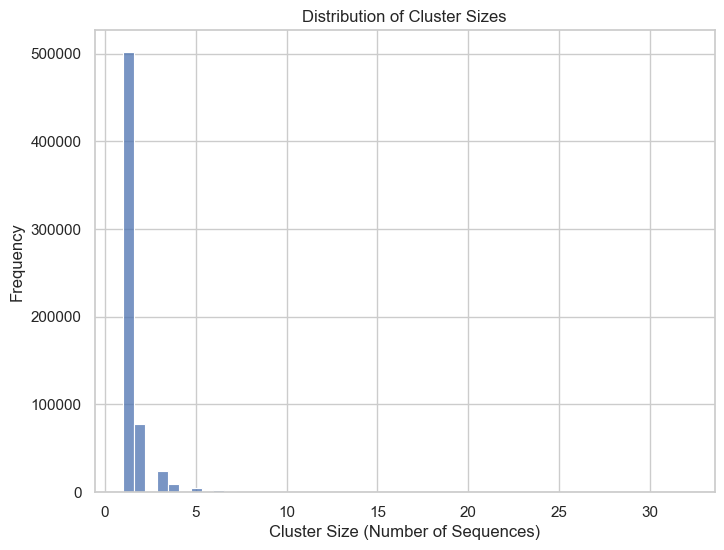

In [180]:
# Plot histogram of cluster sizes
plt.figure(figsize=(8,6))
sns.histplot(cluster_sizes["cluster_size"], bins=50, kde=False)
plt.xlabel("Cluster Size (Number of Sequences)")
plt.ylabel("Frequency")
plt.title("Distribution of Cluster Sizes")
plt.show()

#### an alternative is to construct a distance matrix directly but is  o(n2) time, so only for small datasets

In [182]:
# Install rapidfuzz if not already installed:

from rapidfuzz import distance
import numpy as np
from sklearn.cluster import DBSCAN
from tqdm import tqdm

# Example: a small list of sequences (replace with a subset of your million sequences)
sequences = df.CDR3.tolist()

# Define a custom function using rapidfuzz's Levenshtein distance
def lev_distance(seq1, seq2):
    return distance.Levenshtein.distance(seq1, seq2)

# Build a distance matrix for the small set (O(n²) time and memory; not scalable for millions)
n = len(sequences)
D = np.zeros((n, n))
for i in tqdm(range(n)):
    for j in range(i + 1, n):
        d = lev_distance(sequences[i], sequences[j])
        D[i, j] = d
        D[j, i] = d

# Use DBSCAN to cluster sequences with eps set to desired maximum edit distance (e.g., 2)
clustering = DBSCAN(eps=2, min_samples=1, metric="precomputed")
labels = clustering.fit_predict(D)
print("Cluster labels:", labels)

  0%|                                                                                                                                                                       | 22/828878 [00:13<145:55:05,  1.58it/s]


KeyboardInterrupt: 

#### alternatives:

•	Spark/PySpark: Best for leveraging a full cluster with built-in DataFrame operations and UDFs for large-scale similarity joins.

•	Dask: Works well for scaling pandas-like operations across multiple cores or nodes with minimal code changes.

In [189]:
antigen = df['antigen'].iloc[0]

In [190]:
dirpath ='/Volumes/LaCie_d2_Professional_Media/absolut_antibody/PerClass/RawBindingsPerClassMurine/extracted/processed/'
handle =  antigen+"_consolidated.csv"
fpath = os.path.join(dirpath, handle)
df.to_csv(fpath)

In [197]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType

# Start a Spark session.
spark = SparkSession.builder.appName("SequenceClustering").getOrCreate()

# Load your sequences into a DataFrame.
sequences_df = spark.read.csv(fpath, header=True)

# Define a UDF for Levenshtein distance (using Spark's built-in function if possible).
# Spark's SQL functions have a levenshtein() function.
from pyspark.sql.functions import levenshtein

# Perform a self-join on the DataFrame and compute the distance, then filter by threshold.
joined_df = sequences_df.alias("df1").join(sequences_df.alias("df2"), on=[], how="cross") \
    .filter(col("df1.sequence") < col("df2.sequence")) \
    .withColumn("lev_distance", levenshtein(col("df1.sequence"), col("df2.sequence"))) \
    .filter(col("lev_distance") <= 2)

joined_df.show()

25/02/02 23:12:28 WARN Utils: Your hostname, brett.local resolves to a loopback address: 127.0.0.1; using 192.168.1.20 instead (on interface en0)
25/02/02 23:12:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/02 23:12:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: java.lang.UnsupportedOperationException: getSubject is supported only if a security manager is allowed
	at java.base/javax.security.auth.Subject.getSubject(Subject.java:347)
	at org.apache.hadoop.security.UserGroupInformation.getCurrentUser(UserGroupInformation.java:577)
	at org.apache.spark.util.Utils$.$anonfun$getCurrentUserName$1(Utils.scala:2416)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.util.Utils$.getCurrentUserName(Utils.scala:2416)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:329)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at java.base/jdk.internal.reflect.DirectConstructorHandleAccessor.newInstance(DirectConstructorHandleAccessor.java:62)
	at java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:501)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:485)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1575)
